## Author: Jon Anderson
### Date: 10-18-2019
### Lab 1

In this lab we are going to explore the question of what a new Syracuse University Head Football Coach should be paid based on the market. We start with a data set with limited information, we will consider what other data might be helpful to us, bring it in to our current data set and then see exactly what impact certain factors have on salary for NCAA D1 Head Football Coaches.

First, we will import our packages and data:

In [33]:
import pandas as pd
import numpy as np
import os
import requests
import collections as co
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
import statsmodels.api as sm
import statsmodels.formula.api as smf

os.chdir('g:\\gradschool\\bigdata\\lab1')

coaches = pd.read_csv('data\\coaches.csv')

First we need to clean up the data. We can just drop the school's that don't have data on how much their coach is paid, since that is the main thing we are interested in learning about. Those schools are Baylor, BYU, Rice, and Southern - those are private institutions so they are not required to disclose this information. 

We want to do two things with the remaining data. We want to strip all the white space from the cells and then take away all symbols from the columns that hold money values. The raw data is not consistent in how it formats the money values, some have dollar signs and commas, others do not. We will just convert all numbers to not have any symbols. We will use two functions to do this and then apply the function to the appropriate columns.

In [34]:
def stripWhiteSpace(df_col):
    df_col = df_col.str.strip()
    return(df_col)

def cleanCurrencyVals(df_col):
    df_col = df_col.str.replace('$','')
    df_col = df_col.str.replace(',', '')
    df_col = pd.to_numeric(df_col, errors='ignore')
    return(df_col)

coaches = coaches[coaches['SchoolPay'] != '--']
coaches['School']  = stripWhiteSpace(coaches['School'])
coaches['Conference'] = stripWhiteSpace(coaches['Conference'])
coaches['Coach'] = stripWhiteSpace(coaches['Coach'])
coaches['SchoolPay'] = stripWhiteSpace(coaches['SchoolPay'])
coaches['TotalPay'] = stripWhiteSpace(coaches['TotalPay'])
coaches['Bonus'] = stripWhiteSpace(coaches['Bonus'])
coaches['BonusPaid'] = stripWhiteSpace(coaches['BonusPaid'])
coaches['AssistantPay'] = stripWhiteSpace(coaches['AssistantPay'])
coaches['Buyout'] = stripWhiteSpace(coaches['Buyout'])

coaches['SchoolPay'] = cleanCurrencyVals(coaches['SchoolPay'])
coaches['TotalPay'] = cleanCurrencyVals(coaches['TotalPay'])
coaches['Bonus'] = cleanCurrencyVals(coaches['Bonus'])
coaches['BonusPaid'] = cleanCurrencyVals(coaches['BonusPaid'])
coaches['AssistantPay'] = cleanCurrencyVals(coaches['AssistantPay'])
coaches['Buyout'] = cleanCurrencyVals(coaches['Buyout'])

Let's take a quick peak at what our data looks like. We'll display all our columns and then a quick five

In [35]:
print('Columns:')
print(coaches.columns)
print('--'*50)
print('\nFirst Five Rows:')
print(coaches.head(5))

Columns:
Index(['School', 'Conference', 'Coach', 'SchoolPay', 'TotalPay', 'Bonus',
       'BonusPaid', 'AssistantPay', 'Buyout'],
      dtype='object')
----------------------------------------------------------------------------------------------------

First Five Rows:
                  School Conference              Coach  SchoolPay  TotalPay  \
0              Air Force   Mt. West       Troy Calhoun     885000    885000   
1                  Akron        MAC       Terry Bowden     411000    412500   
2                Alabama        SEC         Nick Saban    8307000   8307000   
3  Alabama at Birmingham      C-USA         Bill Clark     900000    900000   
4      Appalachian State   Sun Belt  Scott Satterfield     712500    712500   

     Bonus BonusPaid  AssistantPay    Buyout  
0   247000        --             0        --  
1   225000     50000             0    688500  
2  1100000    500000             0  33600000  
3   950000    165471             0   3847500  
4   295000    14500

The assignment instructions called for bringing in graduation rates data. The most recent data I could find was from 2011, which I retrieved from here: https://web3.ncaa.org/aprsearch/gsrsearch

From looking at GSR and FGR data myself, they do seem to stay relatively sticky year-to-year, I didn't see many significant movements in those scores from one year to the next, but of course those quick shifts do occur. Since we are now 8 years removed from when this data was last available, I would not feel confident that the numbers I have will be a fair representation of what the numbers actually are today.

I have a conjecture that these metrics do not have a strong impact on coach pay. Some anecdotal evidence:

The GSR and FGR data from 2011 does not SEEM to have any kind of relationship with coach pay, based on what I know about the success of some of these programs over the last 20 years. The best graduation rates come from schools that have not had successful football programs or high paid coaches (Charlotte, Northwestern, Duke, Utah State are some examples). The schools that typically have the highest paid coaches (Alabama, Ohio State, Michigan, Texas), are not near the top of the list in FGR. There are some exceptions like Notre Dame who typically have prominent name, high paid coaches and also have very high graduation rates, but that does not SEEM TO BE a common situation.

Of course, this would need proper testing since anecdotes and one-year sample sizes are total no-fly-zones in data analytics. That would require getting something like 20 years worth of data for both coach pay and the FGR/GSR numbers to see if there is a connection. I am not afraid to admit that I do not want to spend the several hours it would take collecting that data (if I could even find it) to do the full test since I am already pretty confident that using these metrics is not the best way to decide on a salary for our new coach here. Therefore, I will import the data and display it in a scatter plot, but I will not be using that as a factor in my final decision.

Alas, let's import those graduation rates, merge them in, show that it worked, and then show a plot:

              School  FGR  GSR
0          Air Force   69   77
1              Akron   61   72
2            Alabama   63   84
3  Appalachian State   67   71
4            Arizona   63   76


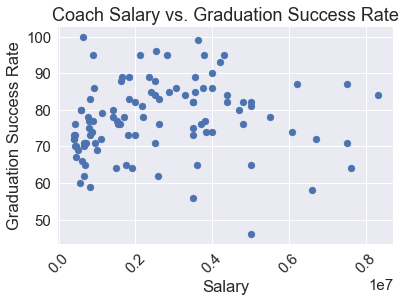

In [36]:
gradrates = pd.read_csv('data\\grad_rates.csv')
coaches = pd.merge(coaches, gradrates, on="School")

viewdf = coaches[['School', 'FGR', 'GSR']]
print(viewdf.head(5))

plt.scatter(coaches['SchoolPay'], coaches['GSR'])
plt.title('Coach Salary vs. Graduation Success Rate')
plt.xlabel('Salary')
plt.ylabel('Graduation Success Rate')
plt.xticks(rotation=45)
plt.show()

No clear relationship, however we know this data is also not even from the same year (GSR from 2011), so we can't say that there is no relationship just based on this plot. Since I suspect that there is not a strong enough relationship between these two things to matter in our modeling and I can't find the current data, we will not be using it from here on.

We need to find data that does impact coach salary. I have come up with this list of data items to get and check:

1. Team success: For this I want more than just one year of data, I want to see the last ten years' winning percentage for each team, since that will tell a much clearer picture about the success of a team relative to how much they pay their coach rather than looking at just one year.
2. Stadium capacity: The size of the stadium tells us something about the prestige of the program, and past successes, and the amount of revenue they generate - all of which ties into how much a school might pay their coach.
3. National Championships: Winning a National Championship is a huge event that creates all kinds of buzz, notoriety, and revenue. Having a school that has recently been the top school in the nation will increase recruiting opportunities and probably drive up the salary for a Head Coach.
4. Recruiting Class Ranks: If a school is constantly has one of the top ranked recruiting class, that definitely says something about the success of the program and may have a negatively correlated relationship with Head Coach salary (since a good rank would be a lower number).

For the first two, I scraped the data using the BeautifulSoup package. The code for those scrapes is below but in a markdown cell out since I was running this from a connection that had a firewall and wouldn't let me scrape external websites. The scrapes do work though if you want to try them! You'll see I just imported the resulting data frames at the end. The URL's I scraped are:

Football Stadium Capacity: https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums
Yearly Records: https://www.sports-reference.com/cfb/years/2018-standings.html (just replace 2018 with whatever year you want)

#### Scraping WikiPedia to get stadium capacities

```python
url='https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')

table = soup.find('table', {'class': 'wikitable sortable'})
table_body = table.find('tbody')

header=['Image', 'Stadium', 'City', 'State', 'School', 'Conference', 'Capacity', 'Record', 'Built', 'Expanded', 'Surface']
trlist=[]
for tr in table_body.findAll('tr'):
    trlist.append(tr)

listofdicts=[]
for row in trlist:
    the_row=[]
    for td in row.findAll('td'):
        the_row.append(td.text)
    od = co.OrderedDict(zip(header, the_row))
    listofdicts.append(od)

df = pd.DataFrame(listofdicts)
df = df.dropna()
df = df[['School', 'Capacity']]

df['School'] = df['School'].str.replace('\n','')
df['Capacity'] = df['Capacity'].str.replace('\n','')
df['Capacity'] = df['Capacity'].str.replace(',','')
df['Capacity'] = df['Capacity'].str.replace(',','')
df['Capacity'] = df['Capacity'].str.replace(',','')

capac_list = df['Capacity'].str.split('[').tolist()
capacities=[]
for x in capac_list:
    capac = x[0]
    capacities.append(capac)
df['Capacity'] = capacities
df = df[['School', 'Capacity']]
df.to_csv('stadium_capacities.csv')
```

#### Scraping for last 10 year's records:
```python
## Scraping 
def cfbScrape(url, year, schools):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    table = soup.find('table', {'class': 'sortable stats_table', 'id': 'standings'})
    table_head = table.find('thead')
    table_body = table.find('tbody')

    header=[]
    for th in table_head.findAll('th'):
        key=th.get_text()
        header.append(key)

    schoollist=[]
    for a in table_body.findAll('a'):
        schoollist.append(a.text)

    schoollist2=[]
    for school in schoollist:
        if school in schools:
            schoollist2.append(school)

    trlist=[]
    for tr in table_body.findAll('tr'):
        trlist.append(tr)

    listofdicts=[]
    for row in trlist:
        the_row=[]
        for td in row.findAll('td'):
            the_row.append(td.text)
        od = co.OrderedDict(zip(header, the_row))
        listofdicts.append(od)

    df = pd.DataFrame(listofdicts)
    df = df.iloc[:,0:5]
    df = df.dropna()
    df.columns = ['Rk', 'Conf', 'Wins', 'Losses', 'Pct']
    df['School'] = schoollist2
    df['Year'] = year

    df = df[['School', 'Year', 'Wins', 'Losses', 'Pct']]
    return(df)

with open('g:\\gradschool\\bigdata\\lab1\\data\\schools.txt') as f:
    schools = f.read().splitlines()

os.chdir('g:\\gradschool\\bigdata\\lab1\\data')
master_df = pd.DataFrame(columns=['School', 'Year', 'Wins', 'Losses', 'Pct'])
years=['2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006']
for year in years:
    print(year)
    url='https://www.sports-reference.com/cfb/years/%s-standings.html' %year
    df = cfbScrape(url, year, schools)
    master_df = pd.concat([master_df, df])
    df.to_csv('Standings%s.csv' %year)

master_df.to_csv('AllStandings.csv')
master_df['Wins'] = pd.to_numeric(master_df['Wins'])
master_df['Losses'] = pd.to_numeric(master_df['Losses'])
comb_standings = master_df.groupby('School', as_index=False)['Wins','Losses'].sum()
comb_standings.to_csv('Last10YearsStandings.csv')
```

I retrieved the National Championships data from here: https://en.wikipedia.org/wiki/College_football_national_championships_in_NCAA_Division_I_FBS

I just copy and pasted the table into Excel and then cut out everything but the last 40 champions, and then used some Excel tricks (the countif & vlookup functions) to get the number of championships for all of the schools in our coaches data.

The recruiting data was retrieved from this source: https://watchstadium.com/news/comparing-college-football-recruiting-rankings-to-number-of-nfl-players-produced-09-04-2019/

This data takes the average of each school's recruiting class rank from 2007-2016. I once again just copied and pasted to Excel and cleaned it up manually.

Let's import all of these data files and merge them in to our coaches dataframe.

In [37]:
## Stadium Capacity ##
stadium_capac = pd.read_csv('data\\stadium_capacities.csv')
stadium_capac = stadium_capac.loc[:, ~stadium_capac.columns.str.contains('^Unnamed')]

## Last 10 years wins and losses ##
winningpct = pd.read_csv('G:\\GradSchool\\BigData\\Lab1\\data\\Last10YearsStandings.csv')
winningpct = winningpct.loc[:, ~winningpct.columns.str.contains('^Unnamed')]
winningpct.columns=['School', 'Wins_10', 'Losses_10', 'Pct_10']
winningpct['Pct_10'] = round(winningpct['Pct_10'],3)
last10pctdf = winningpct[['School', 'Pct_10']]

## Last 40 years Nationals Championship ##
champs = pd.read_csv('data\\championships_last40.csv')

## 2007-2016 recruiting class ranks ##
recruit = pd.read_csv('data\\recruit_ranks.csv')

coaches = pd.merge(coaches, stadium_capac, on="School")
coaches = pd.merge(coaches, winningpct, on="School")
coaches = pd.merge(coaches, champs, on="School")
coaches = pd.merge(coaches, recruit, on="School")

viewdf = coaches[['School', 'Capacity', 'Pct_10', 'Champs', 'RecruitRank']]
print(viewdf.head(5))

              School  Capacity  Pct_10  Champs  RecruitRank
0          Air Force     46692   0.558       0        108.7
1              Akron     30000   0.340       0        109.0
2            Alabama    101821   0.836       7          2.8
3  Appalachian State     30000   0.725       0        117.3
4            Arizona     56029   0.529       0         45.0


Let's see some plots of these 

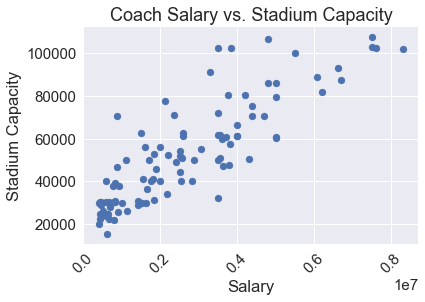

In [38]:
plt.scatter(coaches['SchoolPay'], coaches['Capacity'])
plt.title('Coach Salary vs. Stadium Capacity')
plt.xlabel('Salary')
plt.ylabel('Stadium Capacity')
plt.xticks(rotation=45)
plt.show()

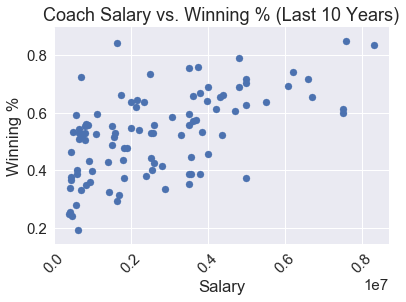

In [39]:
plt.scatter(coaches['SchoolPay'], coaches['Pct_10'])
plt.title('Coach Salary vs. Winning % (Last 10 Years)')
plt.xlabel('Salary')
plt.ylabel('Winning %')
plt.xticks(rotation=45)
plt.show()

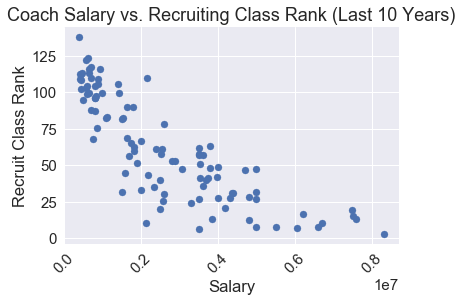

In [40]:
plt.scatter(coaches['SchoolPay'], coaches['RecruitRank'])
plt.title('Coach Salary vs. Recruiting Class Rank (Last 10 Years)')
plt.xlabel('Salary')
plt.ylabel('Recruit Class Rank')
plt.xticks(rotation=45)
plt.show()

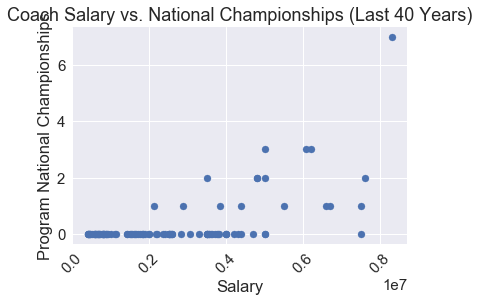

In [41]:
plt.scatter(coaches['SchoolPay'], coaches['Champs'])
plt.title('Coach Salary vs. National Championships (Last 40 Years)')
plt.xlabel('Salary')
plt.ylabel('Program National Championships')
plt.xticks(rotation=45)
plt.show()

All of these graphs suggest some level of a relationship between variables. Let's make a correlation matrix to get the actual numbers on these relationships.

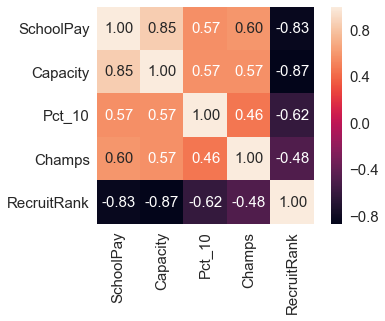

In [42]:
corrdf = coaches[['SchoolPay', 'Capacity', 'Pct_10', 'Champs', 'RecruitRank']]

corrmatrix = np.corrcoef(corrdf.values.T)
sns.set(font_scale=1.5)
heatmap = sns.heatmap(
    corrmatrix,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2F',
    annot_kws={'size': 15},
    yticklabels=corrdf.columns,
    xticklabels=corrdf.columns
    )
plt.show()

Right across that top row we see moderate to strong correlations. Our weakest correlation is .56 between SchoolPay and Winning Percentage, and we have very strong relationships when we look at Capacity and Recruit Rank. As you see, there is some multicollinearity involved here, as Capacity and Recruit Rank are pretty strongly tied together.

Okay, we are ready to build a model using these four predictors.

In [43]:
modeldf = coaches[['Capacity', 'Pct_10', 'Champs', 'RecruitRank', 'SchoolPay']]
modeldf['SchoolPay'] = pd.to_numeric(modeldf['SchoolPay'])
modeldf['RecruitRank'] = pd.to_numeric(modeldf['RecruitRank'])

# Split train & test data sets 
np.random.seed(1234)
modeldf['runiform'] = uniform.rvs(loc=0, scale=1, size=len(modeldf))
traindf = modeldf[modeldf['runiform']>=.33]
testdf = modeldf[modeldf['runiform']<.33]

print('Shape of training DF: ' + str(traindf.shape))
print('Shape of testing DF: ' + str(testdf.shape))

model = str('SchoolPay ~ Capacity + Pct_10 + RecruitRank + Champs')
trainmodel_fit = smf.ols(model, data=traindf).fit()

print('Model Summary:')
print(trainmodel_fit.summary())

# Make predictions
traindf['PredictedSal'] = trainmodel_fit.fittedvalues
testdf['PredictedSal'] = trainmodel_fit.predict(testdf)

coaches['SchoolPay'] = pd.to_numeric(coaches['SchoolPay'])
coaches['PredictedSal'] = trainmodel_fit.predict(coaches)

coaches.to_csv('Coaches_With_Prediction.csv')

filtdf = coaches[['School','SchoolPay','PredictedSal']]
syracuse = filtdf[filtdf['School']=='Syracuse']
print('\n')
print(syracuse)

Shape of training DF: (74, 6)
Shape of testing DF: (27, 6)
Model Summary:
                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     61.05
Date:                Wed, 16 Oct 2019   Prob (F-statistic):           6.02e-22
Time:                        09:59:12   Log-Likelihood:                -1119.1
No. Observations:                  74   AIC:                             2248.
Df Residuals:                      69   BIC:                             2260.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

C:\Users\CRP4552\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\CRP4552\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\CRP4552\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The p-value on Pct_10 is at 0.64 which suggests that might not be a very good factor to use in this model, so we'll run it again without using that in the regression:

In [44]:
modeldf = coaches[['Capacity', 'Pct_10', 'Champs', 'RecruitRank', 'SchoolPay']]
modeldf['SchoolPay'] = pd.to_numeric(modeldf['SchoolPay'])
modeldf['RecruitRank'] = pd.to_numeric(modeldf['RecruitRank'])

# Split train & test data sets 
np.random.seed(1234)
modeldf['runiform'] = uniform.rvs(loc=0, scale=1, size=len(modeldf))
traindf = modeldf[modeldf['runiform']>=.33]
testdf = modeldf[modeldf['runiform']<.33]

print('Shape of training DF: ' + str(traindf.shape))
print('Shape of testing DF: ' + str(testdf.shape))

model = str('SchoolPay ~ Capacity + RecruitRank + Champs')
trainmodel_fit = smf.ols(model, data=traindf).fit()

print('Model Summary:')
print(trainmodel_fit.summary())

# Make predictions
traindf['PredictedSal'] = trainmodel_fit.fittedvalues
testdf['PredictedSal'] = trainmodel_fit.predict(testdf)

coaches['SchoolPay'] = pd.to_numeric(coaches['SchoolPay'])
coaches['PredictedSal'] = trainmodel_fit.predict(coaches)

coaches.to_csv('Coaches_With_Prediction2.csv')

filtdf = coaches[['School','SchoolPay','PredictedSal']]
syracuse = filtdf[filtdf['School']=='Syracuse']
print('\n')
print(syracuse)

Shape of training DF: (74, 6)
Shape of testing DF: (27, 6)
Model Summary:
                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     82.26
Date:                Wed, 16 Oct 2019   Prob (F-statistic):           6.74e-23
Time:                        09:59:12   Log-Likelihood:                -1119.2
No. Observations:                  74   AIC:                             2246.
Df Residuals:                      70   BIC:                             2256.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

C:\Users\CRP4552\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\CRP4552\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\CRP4552\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

After examining the errors for both models in Excel, they came out pretty much exactly the same with pretty insignificant differences in their predictions for each school.

*What is the recommended salary for the Syracuse Football Coach?*

This model suggests that our new coach should be paid 2.38 million dollars, a .8 percent pay decrease from what we were paying the last guy. This model suggests that we were not over or under paying our old coach and we should be looking to keep that salary about the same.

Going just based on these inputs would be short-sighted, of course. There are many other things to consider that we don't see expressed in the data we have available. I doubt any model would say that Alabama should be paying Nick Saban $8.3 million (our model predicted 7.8 - so pretty close actually), but that doesn't mean he is not deserving of that money or much more. Saban is a big name, a coaching legend. His presence at Alabama certainly drives more revenue through ticket and merchandise sales - he really elevates the brand like few other coaches could. Those situations need to be considered, but these predictions make for strong base rates which we can adjust up or down situationally.

*What would his salary be if we were still in the Big East? What if we went to the Big Ten?*

Let's show the average salaries per conference with a bar graph and then a little more about the distributions with a box and whisker plot:

  Conference  SchoolPay
0   Mt. West     885000
1        MAC     411000
2        SEC    8307000
3   Sun Belt     712500
4     Pac-12    1600000
   Conference     AvgSalary  MedianSalary
9         SEC  4.768394e+06     4000000.0
3     Big Ten  4.304014e+06     4095208.5
2      Big 12  3.913760e+06     3654487.5
1         ACC  3.423548e+06     3060018.0
8      Pac-12  2.877543e+06     2878500.0
0         AAC  1.823240e+06     1750000.0
5        Ind.  1.160600e+06      932521.0
7    Mt. West  1.098270e+06      892500.0
4       C-USA  8.524624e+05      762570.0
10   Sun Belt  6.583125e+05      675000.0
6         MAC  5.958356e+05      460000.0
------------------------------------------------------------


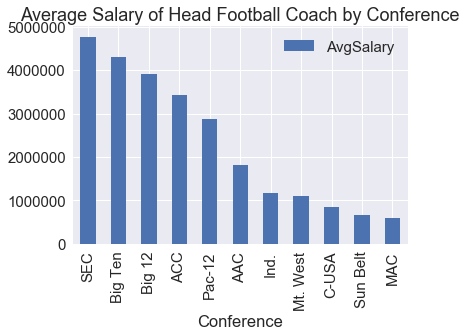

------------------------------------------------------------


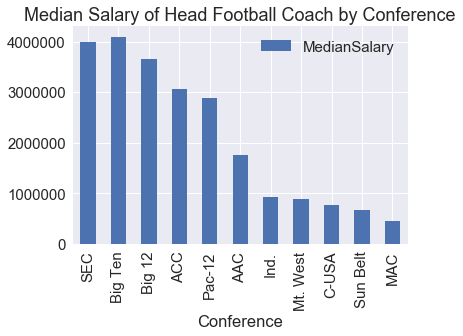

------------------------------------------------------------


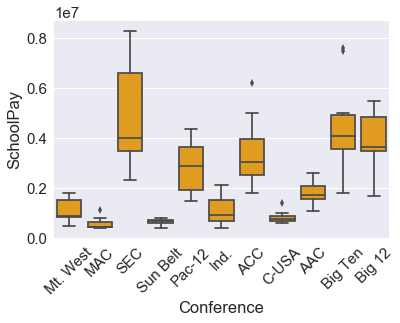

In [45]:
conf_pay_df = coaches[['Conference', 'SchoolPay']]
print(conf_pay_df.head(5))

avgdf = conf_pay_df.groupby('Conference', as_index=False)['SchoolPay'].mean()
meddf = conf_pay_df.groupby('Conference', as_index=False)['SchoolPay'].median()

#avgdf['SchoolPay'] = avgdf['SchoolPay'] / 1000000
#meddf['SchoolPay'] = meddf['SchoolPay'] / 1000000
#avgdf['SchoolPay'] = round(avgdf['SchoolPay'],2)
#meddf['SchoolPay'] = round(meddf['SchoolPay'],2)

viewdf = pd.merge(avgdf, meddf, on='Conference')
viewdf.columns=['Conference', 'AvgSalary', 'MedianSalary']
viewdf = viewdf.sort_values(by=['AvgSalary'], ascending=False)
print(viewdf)
print('--'*30)

viewdf.plot(kind='bar', x='Conference', y='AvgSalary')
plt.title('Average Salary of Head Football Coach by Conference')
plt.show()

print('--'*30)

viewdf.plot(kind='bar', x='Conference', y='MedianSalary')
plt.title('Median Salary of Head Football Coach by Conference')
plt.show()

print('--'*30)

sns.boxplot(x='Conference', y='SchoolPay', data=coaches, color='orange')
plt.xticks(rotation=45)
plt.show()

We can see that Syracuse's current conference (the ACC) sits 4th in average and median head coach salary. The median salary for the Big Ten Conference is 4.1 million, while the ACC sits at 3.06 million. That means as a whole, Big Ten coaches are paid 23.7% more than ACC coaches. It's probably not enough to just take the median/average and find the difference like that, so let's try to find the most comparable school in the Big Ten to Syracuse and see the pay discrepancy.

In [46]:
bigten = coaches[coaches['Conference']=='Big Ten']
bigten = bigten[['School', 'SchoolPay', 'Capacity', 'Pct_10', 'Champs', 'RecruitRank', 'PredictedSal']]
print(bigten.to_string())
print('\n')
syr = coaches[coaches['School']=='Syracuse']
syr = syr[['School', 'SchoolPay', 'Capacity', 'Pct_10', 'Champs', 'RecruitRank', 'PredictedSal']]
print(syr.to_string())

            School  SchoolPay  Capacity  Pct_10  Champs  RecruitRank  PredictedSal
34        Illinois    5000000     60670   0.372       0         47.7  3.011016e+06
35         Indiana    1830000     52959   0.374       0         59.9  2.521003e+06
36            Iowa    4700000     70585   0.606       0         46.5  3.348962e+06
46        Maryland    2512000     51802   0.444       0         39.8  2.889698e+06
48        Michigan    7504000    107601   0.614       1         15.4  5.520628e+06
49  Michigan State    4390417     75005   0.662       0         30.8  3.805411e+06
50       Minnesota    3550000     50805   0.447       0         51.0  2.632306e+06
54        Nebraska    5000000     86047   0.627       2         27.0  4.977889e+06
60    Northwestern    3619775     47130   0.572       0         56.9  2.397044e+06
63      Ohio State    7600000    102082   0.849       2         13.2  5.763569e+06
69      Penn State    4800000    106572   0.690       2         28.0  5.607214e+06
70  

Indiana, Northwestern, Purdue, and Minnesota are pretty similar to Syracuse in terms of stadium capacity, last 10 year's win percentage, and recruiting rank. Let's view them together:

In [47]:
compare = coaches[(coaches['School'] == 'Syracuse') | (coaches['School'] == 'Indiana') |
                 (coaches['School'] == 'Minnesota') | (coaches['School'] == 'Purdue') | 
                 (coaches['School'] == 'Northwestern')]
compare = compare[['School', 'SchoolPay', 'Capacity', 'Pct_10', 'Champs', 'RecruitRank', 'PredictedSal']]
print(compare.to_string())

          School  SchoolPay  Capacity  Pct_10  Champs  RecruitRank  PredictedSal
35       Indiana    1830000     52959   0.374       0         59.9  2.521003e+06
50     Minnesota    3550000     50805   0.447       0         51.0  2.632306e+06
60  Northwestern    3619775     47130   0.572       0         56.9  2.397044e+06
70        Purdue    3800000     57236   0.387       0         63.5  2.583751e+06
77      Syracuse    2401206     49250   0.381       0         61.2  2.377422e+06


Indiana is a different case than most because they have a pretty new coach who is in his first head coaching job. Tom Allen was serving as Indiana's Defensive Coordinator but was quickly promoted to Head Coach in 2016 after their current coach suddenly resigned. He had only served as assistants or defensive coordinators prior to his time at Indiana, so he didn't have much of a case for a big time salary this early on. The other three schools there average 3.6 million for their coaches, with them all being very similarly priced. The 3.6 million dollar average is 33 percent higher than what Syracuse is paying at $2.4 million. I would say that if Syracuse were in the Big Ten we would have to pay the coach 24-35 percent more money, although probably not right away. Joining that conference would likely bring in more revenue for the program in a few different ways. We would likely see more nationally televised games, more game attendance, and more overall exposure. These changes would drive the coaching salary increase, I don't think you'd need to immediately raise that salary 20 percent, maybe just start with a 10 percent raise and bump up the aggressiveness on the yearly increases.

As for the Big East question, well the Big East conference was dissolved in 2013, so to take a crack at this question we'll have to bring in all the schools that were in the last version of the conference.

          School Conference           Coach  SchoolPay  Capacity    Pct_10  Champs  RecruitRank
0     Cincinnati        AAC    Luke Fickell    2000000     40000  0.636364       0         66.8
1    Connecticut        AAC    Randy Edsall    1100000     40000  0.429530       0         82.7
2     Louisville        ACC   Bobby Petrino    3980434     61000  0.640523       0         42.0
3     Pittsburgh        ACC    Pat Narduzzi    3017718     68400  0.549020       0         37.2
4        Rutgers    Big Ten       Chris Ash    2200000     52454  0.539474       0         43.4
5  South Florida        AAC  Charlie Strong    1000000     65857  0.562914       0         57.3
6       Syracuse        ACC     Dino Babers    2401206     49250  0.380952       0         61.2
------------------------------------------------------------


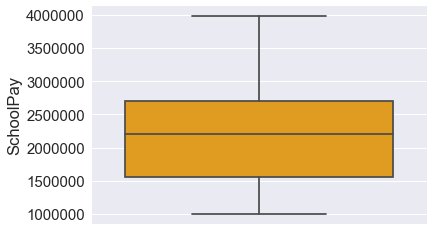

------------------------------------------------------------
          SchoolPay      Capacity    Pct_10  Champs  RecruitRank
count  7.000000e+00      7.000000  7.000000     7.0     7.000000
mean   2.242765e+06  53851.571429  0.534111     0.0    55.800000
std    1.045330e+06  11645.792142  0.097685     0.0    16.156423
min    1.000000e+06  40000.000000  0.380952     0.0    37.200000
25%    1.550000e+06  44625.000000  0.484502     0.0    42.700000
50%    2.200000e+06  52454.000000  0.549020     0.0    57.300000
75%    2.709462e+06  63428.500000  0.599639     0.0    64.000000
max    3.980434e+06  68400.000000  0.640523     0.0    82.700000


In [48]:
bigeastteams = ['Louisville', 'Cincinnati', 'Rutgers', 'Syracuse', 'Pittsburgh', 'Connecticut', 'Temple', 'South Florida']

coaches_orig = pd.read_csv('data\\coaches.csv')
coaches_orig['SchoolPay'] = cleanCurrencyVals(coaches_orig['SchoolPay'])
bigeast = coaches_orig[coaches_orig['School'].isin(bigeastteams)]

comb_standings = pd.read_csv('G:\\GradSchool\\BigData\\Lab1\\data\\Last10YearsStandings.csv')
comb_standings = comb_standings.loc[:, ~comb_standings.columns.str.contains('^Unnamed')]
comb_standings.columns=['School', 'Wins_10', 'Losses_10', 'Pct_10']
last10pctdf = comb_standings[['School', 'Pct_10']]
champs = pd.read_csv('data\\championships_last40.csv')
recruit = pd.read_csv('data\\recruit_ranks.csv')
stadium_capac = pd.read_csv('data\\stadium_capacities.csv')
stadium_capac = stadium_capac.loc[:, ~stadium_capac.columns.str.contains('^Unnamed')]

bigeast = pd.merge(bigeast, stadium_capac, on="School")
bigeast = pd.merge(bigeast, last10pctdf, on='School')
bigeast = pd.merge(bigeast, champs, on='School')
bigeast = pd.merge(bigeast, recruit, on='School')

bigeast = bigeast[['School', 'Conference', 'Coach', 'SchoolPay', 'Capacity', 'Pct_10', 'Champs', 'RecruitRank']]
bigeast['SchoolPay'] = pd.to_numeric(bigeast['SchoolPay'])
#bigeast['SchoolPay'] = bigeast['SchoolPay'] / 1000000
print(bigeast.to_string())
print('--'*30)
sns.boxplot(y='SchoolPay', data=bigeast, color='orange')
plt.xticks(rotation=45)
plt.show()
print('--'*30)
print(bigeast.describe())

We see that our average school pay is 2.24 million and the median is 2.2. Syracuse has had the least success of the group over the last ten years and has one of the smaller stadiums. They do have a stronger recruiting rank than all but Cincinnati and Connecticut. There really aren't any prominent football programs in the former Big East outside of Louisville, so I would guess that if this conference were re-assembled we would see salaries on the lower end. I think Syracuse's 2.4 million is about right, but if anything maybe we'd expect it to tick down to closer to 2 million.

That's the end of my story, thanks for reading!